# Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import SimpleRNN 
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data set

In [2]:
# Monthly series
df1 = pd.read_csv("files/Monthly stationary series.csv")
# Extracted features
df2 = pd.read_csv("files/Monthly Extracted Features.csv")
df2.columns.array[0] = 'DATE 2 Features'
# Combine
features = pd.concat([df1, df2], axis=1)
features = features.drop('DATE 2 Features', axis=1) # Drop 'DATE' column for redundancy
features = features.drop(0)                       # Drop first row
features = features.drop(features.index[-1])      # Drop last row
features = features.reset_index(drop=True)

# Target
target = pd.read_csv("files/Target.csv")
complete_set = pd.concat([target, features], axis=1)
complete_set.columns.array[3]= "DATE Features"
print(complete_set.iloc[:, 0:5])

'''
There are two columns with dates, as one functions for the target (see column 0: DATE) at time t+1, and the other (see column 4: DATE Features) for the feature date at time t.
'''

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990          0.100
1    01/04/1990         0.98        0.02    01/03/1990          0.000
2    01/05/1990         0.30        0.70    01/04/1990         -0.600
3    01/06/1990         0.00        1.00    01/05/1990         -0.400
4    01/07/1990         0.00        1.00    01/06/1990          0.400
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021          0.003
378  01/09/2021         0.00        1.00    01/08/2021         -0.253
379  01/10/2021         0.65        0.35    01/09/2021          0.381
380  01/11/2021         0.00        1.00    01/10/2021          2.171
381  01/12/2021         0.67        0.33    01/11/2021          1.518

[382 rows x 5 columns]


# Standardize features

In [3]:
df = complete_set

# Separate the years, target columns, and features
years = df.iloc[:, 3]
target_columns = df.iloc[:, 1:3]
features = df.iloc[:, 4:]

# Identify the indices corresponding to the training and test periods
train_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '1990-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2010-12-31')
valid_and_test_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '2011-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2021-12-31')

# Extract the training and test features
X_train = features[train_indices]
X_valid_and_test = features[valid_and_test_indices]

# Calculate mean and standard deviation using only the training data
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Standardize the training and test features using the training statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_and_test_scaled = scaler.transform(X_valid_and_test)

# Replace the original feature columns with the standardized ones
df.iloc[train_indices, 4:] = X_train_scaled
df.iloc[valid_and_test_indices, 4:] = X_valid_and_test_scaled
print(df.iloc[:, :5])
df.to_csv("files/Standardized features.csv")

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990       0.138627
1    01/04/1990         0.98        0.02    01/03/1990       0.015108
2    01/05/1990         0.30        0.70    01/04/1990      -0.726010
3    01/06/1990         0.00        1.00    01/05/1990      -0.478971
4    01/07/1990         0.00        1.00    01/06/1990       0.509186
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021       0.018813
378  01/09/2021         0.00        1.00    01/08/2021      -0.297397
379  01/10/2021         0.65        0.35    01/09/2021       0.485718
380  01/11/2021         0.00        1.00    01/10/2021       2.696720
381  01/12/2021         0.67        0.33    01/11/2021       1.890136

[382 rows x 5 columns]


# SRNN: tune hyper-parameters for one window

SRNN: tune hyper-parameters for one window

- Each layer can have a unique number of neurons. 
- The dropout rate is the same in each hidden layer
- Batch normalization occurs after each hidden layer or does not occur at all


In [5]:
# Set the seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def optimize_hyperparameters(X_train, y_train, X_val, y_val):
    def build_model(hp):

        model = Sequential()
        
        # Input layer & first hidden layer
        model.add(SimpleRNN(units=hp.Choice('N_neurons_layer_1', values=[8, 16, 32, 64, 128]), input_shape=(68, 1), activation = 'tanh'))
        model.add(Dropout(hp.Choice('Dropout_rate', values=[0.0, 0.25, 0.5])))
        if hp.Choice('Batch_normalization', values=[True, False]):
            model.add(BatchNormalization())

        # Minimum of 2 and maximum of 3 hidden layers
        n_hidden_layers = hp.Choice('N_hidden_layers', values=[2, 3])
        
        # Layer 2
        if n_hidden_layers == 2:
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())    
        else:
            # Layer 2
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())
                                    
            # Layer 3
            model.add(Dense(units=hp.Choice('N_neurons_layer_3', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())

                
        # Output: weight_stock_index & weight_bond_index
        model.add(Dense(units=2, activation='softmax'))

        # Learning rate can be the learning rate or either one level below or above the learning rate
        lr = hp.Choice('Learning_rate', values=[0.01, 0.0001, 0.001])
        optimizer = keras.optimizers.Adam(learning_rate=lr)

        # Compile model
        model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

        return model

    # The BayesianOptimization tuner is selected
    tuner = kt.RandomSearch(
        build_model,
        objective=kt.Objective('val_mean_absolute_error', direction='min'),
        max_trials=100,
        seed=42,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite= True)
        
    # Perform the hyperparameter search
    tuner.search(x=X_train,
                 y=y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(X_val, y_val))

     # Get the best hyperparameters and the best trial
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters = best_trial.hyperparameters

    return best_hyperparameters.values

# MLP: call function for each window to extract tuned hyper-parameters

In [6]:
# Pre-define table for hyper-parameter results
hp_results = pd.DataFrame(
    {"Window":                 [None, None, None, None, None, None],
     "N_hidden_layers":        [None, None, None, None, None, None],
     "N_neurons_layer_1":      [None, None, None, None, None, None],
     "N_neurons_layer_2":      [None, None, None, None, None, None],
     "N_neurons_layer_3":      [None, None, None, None, None, None],
     "Batch_normalization":    [None, None, None, None, None, None],
     "Dropout_rate":           [None, None, None, None, None, None],
     "Learning_rate":          [None, None, None, None, None, None],
     "MAE":                    [None, None, None, None, None, None]
    })

# Date (column 1), target (column B & C), Sharpe ratio (Column D), & features (column E & onwards)
exclude_bottom = ['1990', '1991', '1992', '1993', '1994']
exclude_top = ['2016', '2017', '2018', '2019', '2020', '2021']
validation_years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

start_year_validation = 0
end_year_validation = 5
for window in range(6):
    print(window)
    # Getting training data
    exclude_1 = exclude_bottom[:window]
    exclude_2 = exclude_top[window:]
    exclude_concat = exclude_1 + exclude_2
    full_window = df[~df['DATE'].str.contains('|'.join(exclude_concat))]
    
    # Training + validation set
    val_years = validation_years[start_year_validation:end_year_validation]
    train_set = full_window[~full_window['DATE'].str.contains('|'.join(val_years))]

    X_train = train_set.iloc[:, 4:]
    X_train = X_train.to_numpy()
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = train_set.iloc[:, [1, 2]]
    
    # Validation set
    val_set = full_window[full_window['DATE'].str.contains('|'.join(val_years))]
    X_val = val_set.iloc[:, 4:]
    X_val = X_val.to_numpy()  
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = val_set.iloc[:, [1, 2]]
    
    results_one_window = optimize_hyperparameters(X_train, y_train, X_val, y_val)
    
    #Allocate results to dataframe
    hp_results.at[window, "Window"] = window
    hp_results.at[window, "N_hidden_layers"] = results_one_window['N_hidden_layers']
    hp_results.at[window, "N_neurons_layer_1"] = results_one_window['N_neurons_layer_1'] 
    hp_results.at[window, "N_neurons_layer_2"] = results_one_window['N_neurons_layer_2'] 
    
    if results_one_window['N_hidden_layers'] == 3:
        hp_results.at[window, "N_neurons_layer_3"] = results_one_window['N_neurons_layer_3'] 
    else: 
        hp_results.at[window, "N_neurons_layer_3"] = None
        
    hp_results.at[window, "Batch_normalization"] = results_one_window['Batch_normalization'] 
    hp_results.at[window, "Dropout_rate"] = results_one_window['Dropout_rate'] 
    hp_results.at[window, "Learning_rate"] = results_one_window['Learning_rate'] 

    start_year_validation += 1
    end_year_validation += 1

hp_results.to_csv("SRNN HP Results.csv")
print(hp_results)

Trial 100 Complete [00h 00m 07s]
val_mean_absolute_error: 0.3346349596977234

Best val_mean_absolute_error So Far: 0.30902615189552307
Total elapsed time: 00h 12m 44s
  Window N_hidden_layers N_neurons_layer_1 N_neurons_layer_2  \
0      0               2               128                64   
1      1               2                64                 8   
2      2               3               128                64   
3      3               2                16                 8   
4      4               3                 8                16   
5      5               2                64                 8   

  N_neurons_layer_3 Batch_normalization Dropout_rate Learning_rate   MAE  
0              None                   1          0.0          0.01  None  
1              None                   1         0.25         0.001  None  
2                64                   1         0.25         0.001  None  
3              None                   1         0.25          0.01  None  
4        

# SRNN: get results on test set for one window

In [4]:
def test_set(X_train, y_train, X_test, y_test, n_layers, n_neurons_L1, n_neurons_L2, n_neurons_L3, batch_normalization, dropout_rate, learning_rate):
    
    # Set the seed for reproducibility
    seed_value = 42
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
    model = Sequential()
    print(X_train.shape)
    # Input layer and first hidden layer
    model.add(SimpleRNN(units=n_neurons_L1, input_shape=(68, 1), activation='tanh'))
    # Dropout layer & Batch normalization layer
    model.add(Dropout(dropout_rate))    
    if batch_normalization == True:
        model.add(BatchNormalization())

    # Second hidden layer
    if n_layers == 2:
        model.add(Dense(units=n_neurons_L2, activation='relu'))
        model.add(Dropout(dropout_rate))   
        if batch_normalization == True:
            model.add(BatchNormalization())

        # Possible third hidden layer
        if n_layers == 3:
            model.add(Dense(units=n_neurons_L3, activation='relu'))
            model.add(Dropout(dropout_rate))    
            if batch_normalization == True:
                model.add(BatchNormalization())

        # Output: weight_stock_index & weight_bond_index
    model.add(Dense(units=2, activation='softmax'))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    loss, mae = model.evaluate(X_test, y_test)

    # Calculate R-squared
    r_squared = r2_score(y_test, y_pred)
    return mae, r_squared, y_test, y_pred

# SRNN: call function for each window to extract all test results

(310, 68)
Epoch 1/10
10/10 [==============================] - 3s 89ms/step - loss: 0.4344 - mae: 0.4344
Epoch 2/10
10/10 [==============================] - 1s 68ms/step - loss: 0.3622 - mae: 0.3622
Epoch 3/10
10/10 [==============================] - 1s 58ms/step - loss: 0.3526 - mae: 0.3526
Epoch 4/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3746 - mae: 0.3746
Epoch 5/10
10/10 [==============================] - 1s 66ms/step - loss: 0.3625 - mae: 0.3625
Epoch 6/10
10/10 [==============================] - 1s 76ms/step - loss: 0.3516 - mae: 0.3516
Epoch 7/10
10/10 [==============================] - 1s 76ms/step - loss: 0.3497 - mae: 0.3497
Epoch 8/10
10/10 [==============================] - 1s 66ms/step - loss: 0.3449 - mae: 0.3449
Epoch 9/10
10/10 [==============================] - 1s 66ms/step - loss: 0.3485 - mae: 0.3485
Epoch 10/10
1/1 [==============================] - 0s 313ms/step - loss: 0.3176 - mae: 0.3176


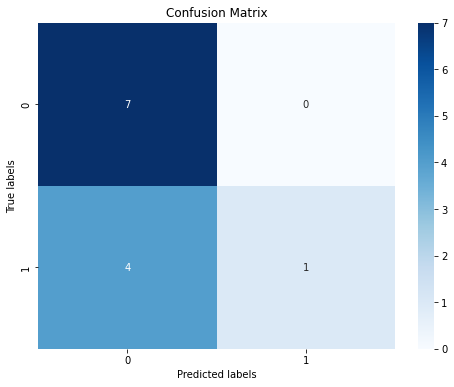

(312, 68)
Epoch 1/10
10/10 [==============================] - 2s 57ms/step - loss: 0.3970 - mae: 0.3970
Epoch 2/10
10/10 [==============================] - 1s 56ms/step - loss: 0.4144 - mae: 0.4144
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 0.3837 - mae: 0.3837
Epoch 4/10
10/10 [==============================] - 1s 47ms/step - loss: 0.3854 - mae: 0.3854
Epoch 5/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3785 - mae: 0.3785
Epoch 6/10
10/10 [==============================] - 1s 55ms/step - loss: 0.3605 - mae: 0.3605
Epoch 7/10
10/10 [==============================] - 1s 46ms/step - loss: 0.3702 - mae: 0.3702
Epoch 8/10
10/10 [==============================] - 1s 88ms/step - loss: 0.3609 - mae: 0.3609
Epoch 9/10
10/10 [==============================] - 1s 78ms/step - loss: 0.3681 - mae: 0.3681
Epoch 10/10
1/1 [==============================] - 1s 605ms/step - loss: 0.2706 - mae: 0.2706


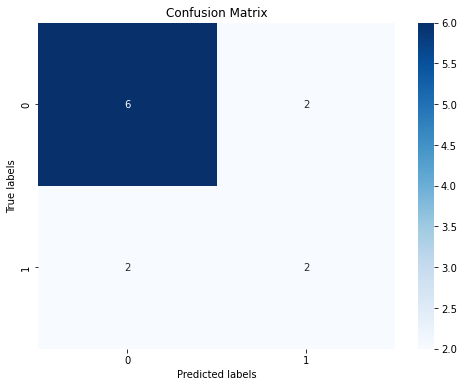

(312, 68)
Epoch 1/10
10/10 [==============================] - 2s 76ms/step - loss: 0.4467 - mae: 0.4467
Epoch 2/10
10/10 [==============================] - 1s 67ms/step - loss: 0.4216 - mae: 0.4216
Epoch 3/10
10/10 [==============================] - 1s 67ms/step - loss: 0.3881 - mae: 0.3881
Epoch 4/10
10/10 [==============================] - 1s 67ms/step - loss: 0.3832 - mae: 0.3832
Epoch 5/10
10/10 [==============================] - 1s 65ms/step - loss: 0.3773 - mae: 0.3773
Epoch 6/10
10/10 [==============================] - 1s 57ms/step - loss: 0.3488 - mae: 0.3488
Epoch 7/10
10/10 [==============================] - 1s 67ms/step - loss: 0.3573 - mae: 0.3573
Epoch 8/10
10/10 [==============================] - 1s 67ms/step - loss: 0.3638 - mae: 0.3638
Epoch 9/10
10/10 [==============================] - 1s 67ms/step - loss: 0.3850 - mae: 0.3850
Epoch 10/10
1/1 [==============================] - 0s 297ms/step - loss: 0.5030 - mae: 0.5030


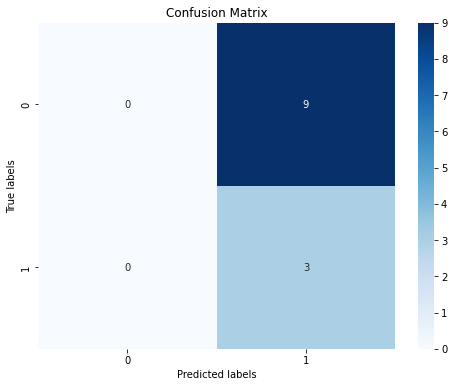

(312, 68)
Epoch 1/10
10/10 [==============================] - 3s 44ms/step - loss: 0.4213 - mae: 0.4213
Epoch 2/10
10/10 [==============================] - 0s 43ms/step - loss: 0.3932 - mae: 0.3932
Epoch 3/10
10/10 [==============================] - 0s 43ms/step - loss: 0.3738 - mae: 0.3738
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 0.3684 - mae: 0.3684
Epoch 5/10
10/10 [==============================] - 0s 31ms/step - loss: 0.3717 - mae: 0.3717
Epoch 6/10
10/10 [==============================] - 0s 31ms/step - loss: 0.3782 - mae: 0.3782
Epoch 7/10
10/10 [==============================] - 0s 24ms/step - loss: 0.3772 - mae: 0.3772
Epoch 8/10
10/10 [==============================] - 0s 34ms/step - loss: 0.3684 - mae: 0.3684
Epoch 9/10
10/10 [==============================] - 0s 33ms/step - loss: 0.3643 - mae: 0.3643
Epoch 10/10
1/1 [==============================] - 0s 366ms/step - loss: 0.3417 - mae: 0.3417


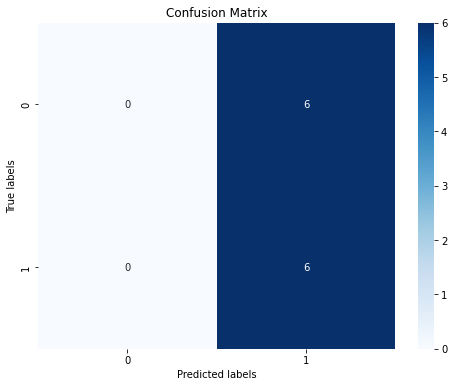

(312, 68)
Epoch 1/10
10/10 [==============================] - 2s 35ms/step - loss: 0.4061 - mae: 0.4061
Epoch 2/10
10/10 [==============================] - 0s 33ms/step - loss: 0.3798 - mae: 0.3798
Epoch 3/10
10/10 [==============================] - 0s 44ms/step - loss: 0.3638 - mae: 0.3638
Epoch 4/10
10/10 [==============================] - 0s 33ms/step - loss: 0.3657 - mae: 0.3657
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.3557 - mae: 0.3557
Epoch 6/10
10/10 [==============================] - 0s 24ms/step - loss: 0.3527 - mae: 0.3527
Epoch 7/10
10/10 [==============================] - 0s 34ms/step - loss: 0.3500 - mae: 0.3500
Epoch 8/10
10/10 [==============================] - 0s 33ms/step - loss: 0.3524 - mae: 0.3524
Epoch 9/10
10/10 [==============================] - 0s 32ms/step - loss: 0.3581 - mae: 0.3581
Epoch 10/10
1/1 [==============================] - 0s 299ms/step - loss: 0.3397 - mae: 0.3397


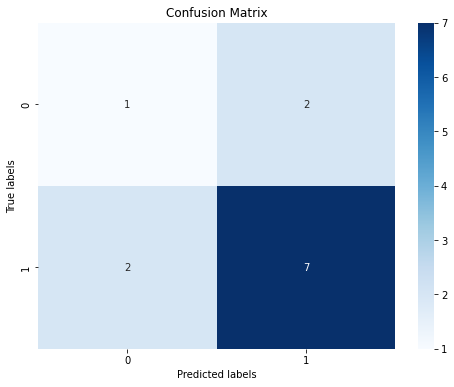

(312, 68)
Epoch 1/10
10/10 [==============================] - 2s 57ms/step - loss: 0.3943 - mae: 0.3943
Epoch 2/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3958 - mae: 0.3958
Epoch 3/10
10/10 [==============================] - 0s 53ms/step - loss: 0.4057 - mae: 0.4057
Epoch 4/10
10/10 [==============================] - 1s 55ms/step - loss: 0.3850 - mae: 0.3850
Epoch 5/10
10/10 [==============================] - 1s 46ms/step - loss: 0.3792 - mae: 0.3792
Epoch 6/10
10/10 [==============================] - 1s 54ms/step - loss: 0.3524 - mae: 0.3524
Epoch 7/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3517 - mae: 0.3517
Epoch 8/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3430 - mae: 0.3430
Epoch 9/10
10/10 [==============================] - 1s 55ms/step - loss: 0.3611 - mae: 0.3611
Epoch 10/10
1/1 [==============================] - 0s 359ms/step - loss: 0.2665 - mae: 0.2665


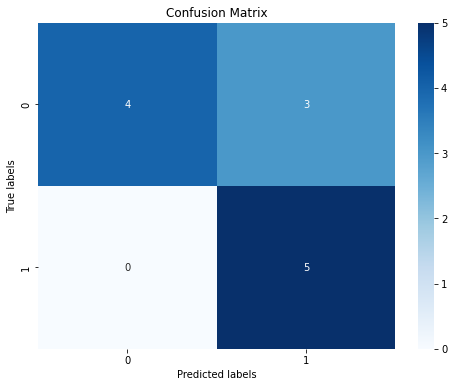

  Window    MAE R_squared Accuracy F1 Score
0      0  0.318     0.113    0.667    0.593
1      1  0.271    -0.489    0.667    0.667
2      2  0.503    -0.939     0.25      0.1
3      3  0.342    -0.506      0.5    0.333
4      4   0.34    -0.043    0.667    0.667
5      5  0.266     0.343     0.75    0.745


In [6]:
# Import tuned hyper-paramters
hp_results = pd.read_csv("Final results/SRNN HP Results.csv")

# Years that will be removed from the data set (depending on the window)
bottom_years = ["1990", "1991", "1992", "1993","1994"]
test_years = ["2016", "2017", "2018", "2019", "2020", "2021"]

# Define table to store results
result_SRNN = pd.DataFrame(
{"Window":              [None, None, None, None, None, None],
 "MAE":                 [None, None, None, None, None, None],
 "R_squared":           [None, None, None, None, None, None],
 "Accuracy":            [None, None, None, None, None, None],
 "F1 Score":            [None, None, None, None, None, None]
})

# Define np array to store actual and predicted weights
weights_results = pd.DataFrame([[None] * 5] * 72, columns=['Date', 'Actual Stock Weight', 'Actual Bond Weight', 'Predicted Stock Weight', 'Predicted Bond Weight'])

# Loop over each 
for window in range(6):
    # Retrieve hyper-parameters for window
    Window = hp_results.loc[window, ['Window']][0]
    N_hidden_layers = int(hp_results.loc[window, ['N_hidden_layers']][0])
    N_neurons_layer_1 = N_neurons_layer_3 = int(hp_results.loc[window, ['N_neurons_layer_1']][0])
    N_neurons_layer_2 = N_neurons_layer_3 = int(hp_results.loc[window, ['N_neurons_layer_2']][0])

    if N_hidden_layers == 3:
        N_neurons_layer_3 = int(hp_results.loc[window, ['N_neurons_layer_3']][0])
    else:
        N_neurons_layer_3 = hp_results.loc[window, ['N_neurons_layer_3']][0]
    Batch_normalization = int(hp_results.loc[window, ['Batch_normalization']][0])
    Dropout_rate = hp_results.loc[window, ['Dropout_rate']][0]
    Learning_rate = hp_results.loc[window, ['Learning_rate']][0]


    # Exluce the bottom years in training set (depending on window)
    exclude_bottom_years = bottom_years[0:window]
    
    # Exclude test years in training set (depending on window)
    exclude_test_years = test_years[window:]
    
    # Merge years to exclude for training set (depending on window)
    train_exclude= exclude_bottom_years + exclude_test_years

    # Retrieve test year (depending on window)
    test_year = test_years[window]
   
    # Get filtered data set 
    whole_train = df[~df['DATE'].str.contains('|'.join(train_exclude))]
    whole_test = df[df['DATE'].str.contains(test_year)]

    # Select right columns
    X_train = whole_train.iloc[:, 4:]
    y_train = whole_train.iloc[:, [1, 2]]
    X_test = whole_test.iloc[:, 4:]
    y_test = whole_test.iloc[:, [1, 2]]
    
    # Extract results for each window
    result_window = test_set(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_layers=N_hidden_layers, n_neurons_L1=N_neurons_layer_1,n_neurons_L2=N_neurons_layer_2, n_neurons_L3=N_neurons_layer_3, batch_normalization=Batch_normalization, dropout_rate=Dropout_rate, learning_rate=Learning_rate)
    
    # Assign results to table
    
    dates = list(whole_test.loc[:, "DATE"])
    weights_results.loc[window*12:(window*12+11), "Date"] = dates
    stock_optimal = list(whole_test.loc[:, "Stock index"])
    weights_results.loc[window*12:(window*12+11), "Actual Stock Weight"] = stock_optimal
    bond_optimal = list(whole_test.loc[:, "Bond Index"])
    weights_results.loc[window*12:(window*12+11), "Actual Bond Weight"] = bond_optimal
    pred_stock = list(result_window[3][:, 0])
    weights_results.loc[window*12:(window*12+11), "Predicted Stock Weight"] = pred_stock
    pred_bond = list(result_window[3][:, 1])
    weights_results.loc[window*12:(window*12+11), "Predicted Bond Weight"] = pred_bond
    
    # Assign results to table
    result_SRNN.at[window, "Window"] = window
    result_SRNN.at[window, "MAE"] = np.round(result_window[0], 3)
    result_SRNN.at[window, "R_squared"] = np.round(result_window[1], 3)
    
    # Rounc for classification results
    round_actual = np.round(result_window[2]).values #convert to np array
    round_pred = np.round(result_window[3])
    row_matches = np.all(round_pred == round_actual, axis=1)

    # Get accuracy and F1 score
    y_pred = (round_pred > 0.5)
    acc = accuracy_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    result_SRNN.at[window, "Accuracy"] = round(acc, 3)
    f1 = f1_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
    result_SRNN.at[window, "F1 Score"] = round(f1, 3)
    	
    # Plot confusion matrix
    cm = confusion_matrix(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
   
result_SRNN.to_csv("Final results/SRNN Final Results.csv")
weights_results.to_csv("Final results/SRNN Weight predictions.csv")
print(result_SRNN)